In [129]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [130]:
%config InlineBackend.figure_format = 'retina'

In [131]:
DOMAIN = "compositional_graphics"

EXPERIMENT_ID_BASELINE = "logo_stitch_iterative"
EXPERIMENT_ID_CODEX = "logo_codex_stitch_iterative_default"
EXPERIMENT_ID_ORACLE = "logo_stitch_oracle"

# EXPERIMENT_ID_BASELINE = "logo_stitch_iterative_inv1"
# EXPERIMENT_ID_CODEX = "logo_codex_stitch_iterative_default_inv1"

# EXPERIMENT_ID_BASELINE = "logo_stitch_random"
# EXPERIMENT_ID_CODEX = "logo_codex_stitch_random"

# EXPERIMENT_ID_CODEX = "logo_codex_stitch_iterative_human_readable"

# DOMAIN = "clevr"

# EXPERIMENT_ID_BASELINE = "clevr_stitch_iterative"
# EXPERIMENT_ID_CODEX = "clevr_codex_stitch_iterative"

In [132]:
DIR_ITERATIVE_BASELINE = f"../experiments/outputs/{DOMAIN}/{EXPERIMENT_ID_BASELINE}/"
DIR_ITERATIVE_CODEX = f"../experiments/outputs/{DOMAIN}/{EXPERIMENT_ID_CODEX}/"
DIR_ITERATIVE_ORACLE = f"../experiments/outputs/{DOMAIN}/{EXPERIMENT_ID_ORACLE}/"

In [133]:
def get_log_likelihoods(dir_results, split):
    data = []

    for path in sorted(glob.glob(os.path.join(dir_results, "*"))):
        config_json_path = os.path.join(path, "config.json")
        with open(config_json_path, "r") as f:
            config = json.load(f)
        global_batch_size = config["experiment_iterator"]["task_batcher"]["params"][
            "global_batch_size"
        ]

        test_likelihoods_json_path = os.path.join(path, "0", "test_likelihoods.json")
        with open(test_likelihoods_json_path, "r") as f:
            likelihoods_data = json.load(f)

        stitch_frontiers_json_path = os.path.join(
            path, "0", split, "stitch_frontiers.json"
        )
        with open(stitch_frontiers_json_path, "r") as f:
            stitch_frontiers_data = json.load(f)

        for task_name, ll_list in likelihoods_data["log_likelihoods_by_task"][
            "test"
        ].items():
            data.append(
                {
                    "batch_size": global_batch_size,
                    "task_name": task_name,
                    "log_likelihood": ll_list[0],
                    "description_length": likelihoods_data["description_lengths_by_task"]["test"][task_name][0],
                    "n_frontiers": len(stitch_frontiers_data["frontiers"]),
                }
            )

    df = pd.DataFrame(data)
    return df

In [134]:
df1 = get_log_likelihoods(DIR_ITERATIVE_BASELINE, "train")
df1["condition"] = "Stitch"

df2 = get_log_likelihoods(DIR_ITERATIVE_CODEX, "train")
df2["condition"] = "Stitch + Codex"

df3 = get_log_likelihoods(DIR_ITERATIVE_ORACLE, "test")
df3["condition"] = "Oracle"

In [135]:
df = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True)
BATCH_SIZES = sorted(df.batch_size.unique().tolist())

In [136]:
df

,batch_size,task_name,log_likelihood,description_length,n_frontiers,condition
0,10,a greek spiral with 7 turns,-22.990915,10,10,Stitch
1,10,a 7 pointed star,-35.744369,16,10,Stitch
2,10,a 5 stepped staircase,-41.812794,19,10,Stitch
3,10,8 sided snowflake with a short line and a smal...,-25.927807,11,10,Stitch
4,10,8 sided snowflake with a medium semicircle and...,-24.588032,10,10,Stitch
...,...,...,...,...,...,...
2659,50,7 sided snowflake with a short space and a sho...,-15.627991,6,111,Oracle
2660,50,3 sided snowflake with a short space and a sho...,-15.627991,6,111,Oracle
2661,50,7 sided snowflake with a short space and a sho...,-15.627991,6,111,Oracle
2662,50,6 sided snowflake with a short space and a sho...,-15.627991,6,111,Oracle


In [137]:
BATCH_SIZES

[5, 10, 15, 25, 50, 100, 150, 200]

<AxesSubplot:xlabel='batch_size', ylabel='n_frontiers'>

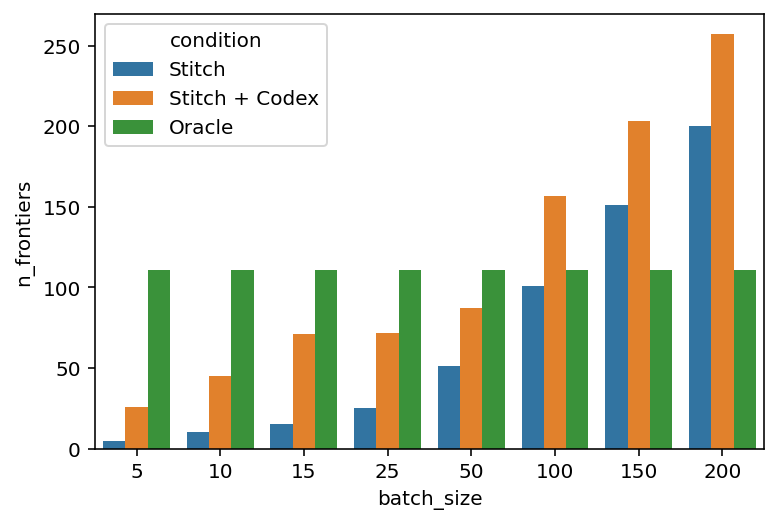

In [138]:
sns.barplot(data=df, x="batch_size", y="n_frontiers", hue="condition")

<AxesSubplot:xlabel='batch_size', ylabel='log_likelihood'>

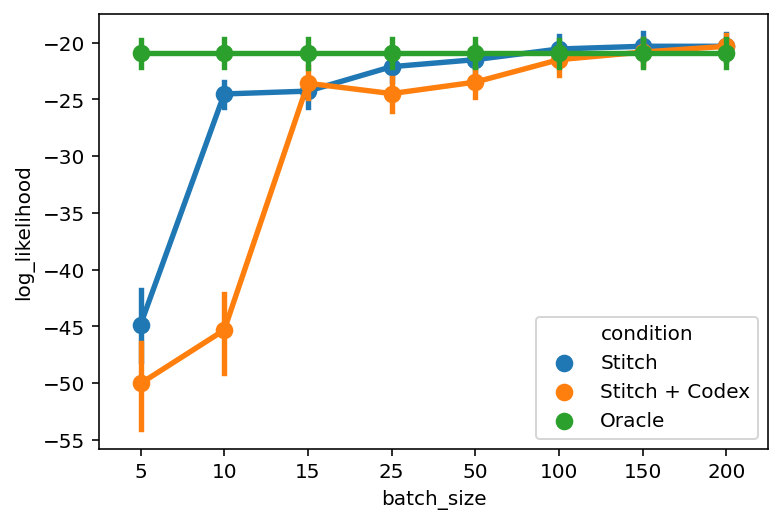

In [139]:
sns.pointplot(data=df, x="batch_size", y="log_likelihood", hue="condition")

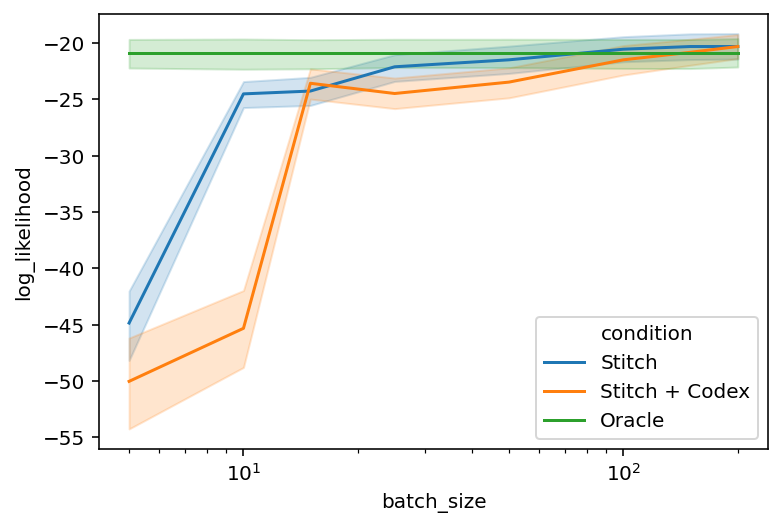

In [140]:
g = sns.lineplot(data=df, x="batch_size", y="log_likelihood", hue="condition")
g.set(xscale="log");

<AxesSubplot:xlabel='batch_size', ylabel='description_length'>

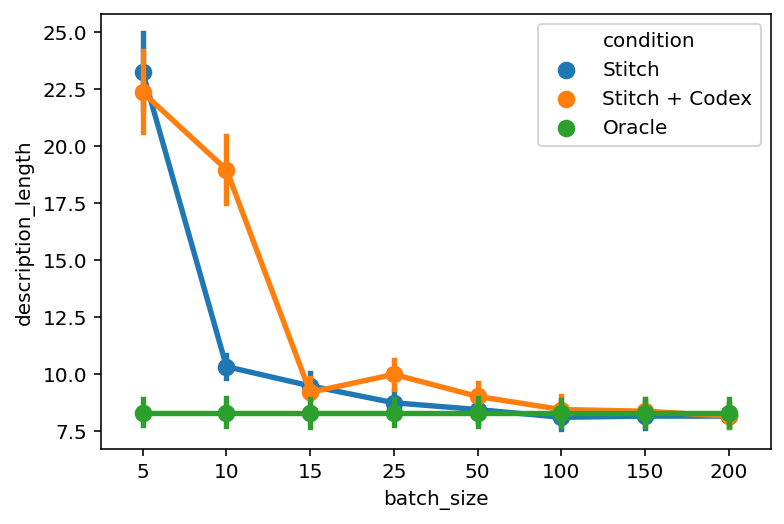

In [141]:
sns.pointplot(data=df, x="batch_size", y="description_length", hue="condition")

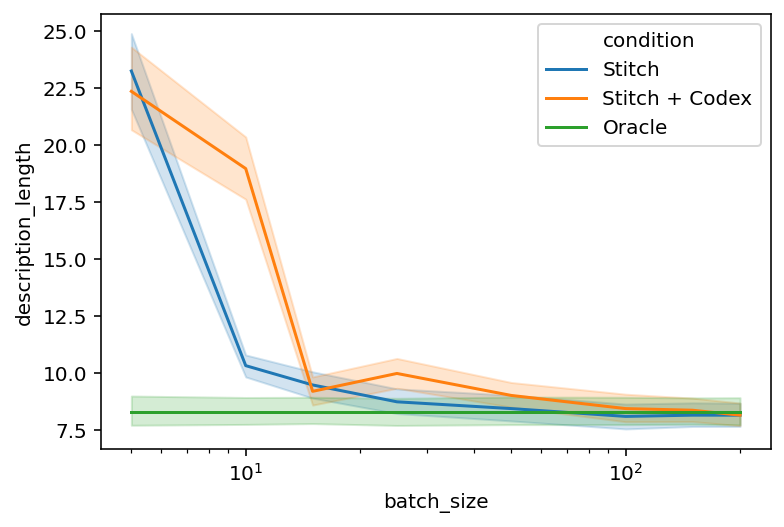

In [142]:
g = sns.lineplot(data=df, x="batch_size", y="description_length", hue="condition")
g.set(xscale="log");

<AxesSubplot:xlabel='description_length', ylabel='log_likelihood'>

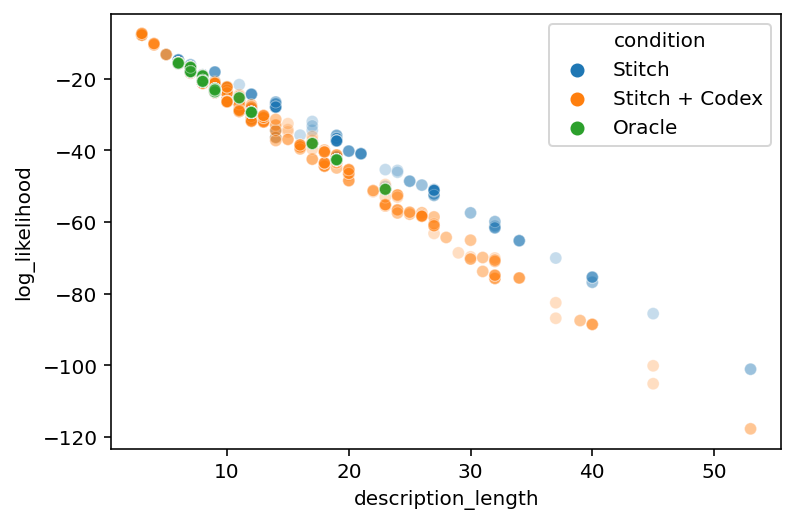

In [143]:
sns.scatterplot(data=df, x="description_length", y="log_likelihood", hue="condition", alpha=0.25)

# What programs does Codex generate?

In [ ]:
codex_query_results_json_paths = glob.glob(
    f"../experiments/outputs/{DOMAIN}/{EXPERIMENT_ID_CODEX}/{EXPERIMENT_ID_CODEX}_*/0/codex_query_results.json"
)

In [ ]:
def get_codex_programs():
    df_list = []
    for batch_size in BATCH_SIZES:
        path = f"../experiments/outputs/{DOMAIN}/{EXPERIMENT_ID_CODEX}/{EXPERIMENT_ID_CODEX}_{batch_size}/0/codex_query_results.json"
        with open(path, "r") as f:
            codex_query_results = json.load(f)

        data = []
        for p in codex_query_results["prompt_programs"]:
            data.append(
                {
                    "program": p,
                    "origin": "train",
                    "valid": True,
                }
            )
        for p in codex_query_results["programs_valid"]:
            data.append(
                {
                    "program": p,
                    "origin": "codex",
                    "valid": True,
                }
            )
        for p in codex_query_results["programs_invalid"]:
            data.append(
                {
                    "program": p,
                    "origin": "codex",
                    "valid": False,
                }
            )

        df = pd.DataFrame(data)
        df["program_str_len"] = df.program.str.len()
        df["batch_size"] = batch_size

        train_programs = set(df[df["origin"] == "train"]["program"])
        df["copied_from_train"] = [
            (row["origin"] == "codex") and (row["program"] in train_programs)
            for _, row in df.iterrows()
        ]

        df_list.append(df)

    #         print(
    #             f"+ From {batch_size} training programs, Codex generated {len(df[df.origin == 'codex'])} programs, for a total of {len(df)} programs."
    #         )
    #         print(
    #             f"+ Of these, {len(df[(df.origin == 'codex') & (df.valid)])} were valid and {len(df[(df.origin == 'codex') & (~df.valid)])} were invalid."
    #         )
    #         print(
    #             f"+ In total, there were {df['program'].nunique()} unique programs; {df[df.valid]['program'].nunique()} were valid."
    #         )

    #         copied_programs = set(codex_query_results["programs_valid"]) & set(
    #             codex_query_results["prompt_programs"]
    #         )
    #         print(
    #             f"+ {len(copied_programs)} of the Codex programs were direct copies from the training data."
    #         )

    return pd.concat(df_list).reset_index(drop=True)

In [ ]:
df_codex = get_codex_programs()

In [ ]:
df_codex

In [ ]:
plt.title("Percentage of valid programs")
sns.barplot(data=df_codex, x="batch_size", y="valid", hue="origin");

In [ ]:
plt.title("Program string length")
sns.violinplot(data=df_codex, x="batch_size", y="program_str_len", hue="origin");

In [ ]:
plt.title("Count of unique programs")
sns.pointplot(
    data=df_codex.groupby("batch_size").nunique().reset_index(),
    x="batch_size",
    y="program",
);

In [ ]:
plt.title("Count of programs copied from train")
sns.pointplot(
    data=df_codex.groupby("batch_size").sum().reset_index(),
    x="batch_size",
    y="copied_from_train",
);

In [ ]:
sns.displot(
    data=df_codex, x="program_str_len", hue="valid", col="origin", row="batch_size"
);

# What inventions are in the libraries?

In [ ]:
def get_library_inventions(experiment_id, split):
    data = []
    for batch_size in BATCH_SIZES:
        path = f"../experiments/outputs/{DOMAIN}/{experiment_id}/{experiment_id}_{batch_size}/0/{split}/stitch_output.json"

        with open(path, "r") as f:
            stitch_output_data = json.load(f)

        df = pd.DataFrame(stitch_output_data["invs"])[
            ["name", "arity", "utility", "multiplier", "body", "dreamcoder"]
        ]
        df["batch_size"] = batch_size
        data.append(df)

    return pd.concat(data, axis=0).reset_index(drop=True)

In [ ]:
df_libraries_baseline = get_library_inventions(EXPERIMENT_ID_BASELINE, "train")
df_libraries_baseline["condition"] = "baseline"

df_libraries_codex = get_library_inventions(EXPERIMENT_ID_CODEX, "train")
df_libraries_codex["condition"] = "codex"

df_libraries_test = get_library_inventions(EXPERIMENT_ID_ORACLE, "test")
df_libraries_test["condition"] = "test"

df_libraries = pd.concat(
    [df_libraries_baseline, df_libraries_codex, df_libraries_test], axis=0
).reset_index(drop=True)

In [ ]:
data_overlap = []
for batch_size, group in df_libraries.groupby("batch_size"):
    fns_baseline = set(group[group.condition == "baseline"].dreamcoder)
    fns_codex = set(group[group.condition == "codex"].dreamcoder)
    fns_test = set(group[group.condition == "test"].dreamcoder)
    data_overlap.append(
        {
            "batch_size": int(batch_size),
            "utility_baseline": group[group.condition == "baseline"]["utility"].sum(),
            "utility_codex": group[group.condition == "codex"]["utility"].sum(),
            "utility_test": group[group.condition == "test"]["utility"].sum(),
            "n_baseline": len(fns_baseline),
            "fns_baseline": fns_baseline,
            "n_codex": len(fns_codex),
            "fns_codex": fns_codex,
            "n_test": len(fns_test),
            "fns_test": fns_test,
            "n_baseline_only": len(fns_baseline - fns_codex),
            "fns_baseline_only": fns_baseline - fns_codex,
            "n_codex_only": len(fns_codex - fns_baseline),
            "fns_codex_only": fns_codex - fns_baseline,
            "n_overlap": len(fns_baseline & fns_codex),
            "fns_overlap": (fns_baseline & fns_codex),
            "n_baseline_test": len(fns_baseline & fns_test),
            "n_codex_test": len(fns_codex & fns_test),
        }
    )

In [ ]:
df_overlap = pd.DataFrame(data_overlap)
df_overlap

In [ ]:
df_overlap_long = df_overlap.rename(dict(zip(["n_baseline_only", "n_codex_only", "n_overlap"], ["baseline_only", "codex_only", "overlap"])), axis="columns")
df_overlap_long = df_overlap_long.melt(id_vars="batch_size", value_vars=["baseline_only", "codex_only", "overlap"], var_name="library", value_name="Inventions (count)")

plt.title("Overlap between Baseline and Codex inventions")
sns.barplot(data=df_overlap_long, x="batch_size", y="Inventions (count)", hue="library")

In [ ]:
df_overlap_long = df_overlap.rename(dict(zip(["n_baseline_test", "n_codex_test", "n_test"], ["Stitch", "Stitch + Codex", "Oracle"])), axis="columns")
df_overlap_long = df_overlap_long.melt(id_vars="batch_size", value_vars=["Stitch", "Stitch + Codex", "Oracle"], var_name="library", value_name="Oracle inventions discovered (count)")

plt.title("Discovery of oracle (test set) inventions")
sns.pointplot(data=df_overlap_long, x="batch_size", y="Oracle inventions discovered (count)", hue="library")

In [ ]:
df_overlap_long

In [ ]:
from matplotlib_venn import venn2, venn3

In [ ]:
os.makedirs("library_venn_diagrams", exist_ok=True)
os.makedirs("library_venn_diagrams/venn2", exist_ok=True)
os.makedirs("library_venn_diagrams/venn3", exist_ok=True)

In [ ]:
for i, row in df_overlap.iterrows():
    plt.figure()
    venn2(
        subsets=(row["n_baseline_only"], row["n_codex_only"], row["n_overlap"]),
        set_labels=("Baseline", "Codex"),
    )
    plt.title("Batch size: " + str(row["batch_size"]))
    plt.savefig(f"library_venn_diagrams/venn2/batch_{row['batch_size']:03d}.png", dpi=144)

In [ ]:
for batch_size, group in df_libraries.groupby("batch_size"):
    fns_baseline = set(group[group.condition == "baseline"].dreamcoder)
    fns_codex = set(group[group.condition == "codex"].dreamcoder)
    fns_test = set(group[group.condition == "test"].dreamcoder)
    plt.figure()
    venn3(
        [fns_baseline, fns_codex, fns_test],
        set_labels=("Baseline", "Codex", "Oracle"),
    )
    plt.title("Batch size: " + str(batch_size))
    plt.savefig(f"library_venn_diagrams/venn3/batch_{int(batch_size):03d}.png", dpi=144)